In [1]:
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import logging

from scipy.stats import kruskal, f_oneway

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy

In [2]:
logging.basicConfig(filename='example.log',level=logging.DEBUG)

In [3]:
# This cmd was used to identify multimodal genes 
cmd = ["docker" ,
       "run",
       "-v", "$PWD:/data",
       "jpfeil/hydra@sha256:123bee0aa2b3e63084c773a13a16d247076462af910a104cd5776ba5e6d4b29d",
       "filter",
       "-e", "data/target-high-risk-nbl-mycn-na-exp-2018-11-12.tsv",
       "--output-dir", "output",
       "--CPU", "15"]

In [4]:
mm_genes = '../data/output/MultiModalGenes/'
exp_path = '../data/expression/target-high-risk-nbl-mycn-na-exp-2018-11-12.tsv'

In [5]:
# Read in expression data
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [6]:
# Save list of multimodal genes
mms = []
for gene in os.listdir(mm_genes):
    mms.append(gene)

In [7]:
# Scan minimum probability thresholds
if False:
    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO', 
                                     min_prob_range=[0.10, 0.15, 0.20, 0.25, 0.3], 
                                     CPU=7,
                                     K=5).scan()

In [8]:
# Perform enrichment analysis - same as enrich command
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.2,
                            gmt_path='GO')

In [9]:
# Load enriched gene set terms
terms = res.get_enriched_terms()

In [10]:
# Extract enriched GO term genes
genes = res.get_enriched_term_genes()

len(genes)

43

In [11]:
# Perform multivariate DP-GMM analysis
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

In [14]:
clus.fit()

centering data


In [15]:
# Format pathway names for printing
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

In [16]:
# Perform GSEA on each cluster
fgsea = clus.get_cluster_features(exp,
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [45]:
# Create dataframe with enriched pathways
fgsea_df = None
for key, values in fgsea.items():
    if fgsea_df is None:
        header = pd.MultiIndex.from_product([list(fgsea.keys()), 
                                             ['padj', 'NES']],
                                           names=['cluster', 'feature'])
        
        fgsea_df = pd.DataFrame(index=values.index.values, columns=header)
        
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(20))
    
    fgsea_df[(key, 'padj')] = values.loc[fgsea_df.index, 'padj'].values
    fgsea_df[(key, 'NES')] = values.loc[fgsea_df.index, 'NES'].values

Key:  0                                               pathway     padj       NES
0            B CELL RECEPTOR SIGNALING PATHWAY (GOBP)  0.00388  3.856311
1     COMPLEMENT ACTIVATION, CLASSICAL PATHWAY (GOBP)  0.00388  3.346792
2                    PHAGOCYTOSIS, RECOGNITION (GOBP)  0.00388  3.300364
3                    HALLMARK_E2F_TARGETS (MSIGDB_C2)  0.00388  3.231393
4     POSITIVE REGULATION OF B CELL ACTIVATION (GOBP)  0.00388  3.205639
5   HUMORAL IMMUNE RESPONSE MEDIATED BY CIRCULATIN...  0.00388  3.195767
6   ANTIGEN RECEPTOR-MEDIATED SIGNALING PATHWAY (G...  0.00388  3.180149
7                     ADAPTIVE IMMUNE RESPONSE (GOBP)  0.00388  3.144741
8                     B CELL MEDIATED IMMUNITY (GOBP)  0.00388  3.144160
9                        LYMPHOCYTE ACTIVATION (GOBP)  0.00388  3.142544
10                           T CELL ACTIVATION (GOBP)  0.00388  3.141501
11                HALLMARK_G2M_CHECKPOINT (MSIGDB_C2)  0.00388  3.134203
12     IMMUNOGLOBULIN MEDIATED IMMUNE RESPO

In [18]:
# Save dataframe for downstream analysis
pth = '../data/TARGET-MYCN-NA-Pathways-Enrichment.tsv'
fgsea_df.to_csv(pth, sep='\t')

In [19]:
# Create LaTEX tables with top 10 enriched pathways
cpth = '../img/TARGET-MYCN-NA-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            #print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

In [20]:
# Save cluster assignments
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [21]:
assign

,1
TARGET-30-PAITCI-01,3
TARGET-30-PAITEG-01,3
TARGET-30-PAIVHE-01,3
TARGET-30-PALBFW-01,3
TARGET-30-PALCBW-01,3
TARGET-30-PALETP-01,1
TARGET-30-PALIIN-01,1
TARGET-30-PALNVP-01,2
TARGET-30-PALTEG-01,1
TARGET-30-PALUYS-01,2


In [22]:
# Save assignments
assign.to_csv('../data/assignments.tsv', sep='\t', header=None)

In [23]:
# Peform hierarchical clustering on multimodal genes
hclust = hy.HClust(data=exp.reindex(genes))

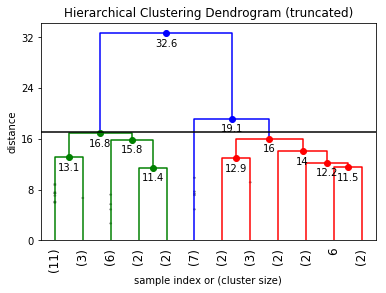

In [24]:
# Plot row linkage with a distance of 17
hclust.plot_row_linkage(17)
row_groups = hclust.get_row_groups(17)

In [25]:
# Load M3C analysis
pth = '../data/cluster-analysis/MYCN-NA-M3C-MAD-5000-labels-2.tsv'
m3c5000 = pd.read_csv(pth, sep='\t')
m3c5000.index = [x.replace('.', '-') for x in m3c5000.index.values]
m3c5000 = m3c5000.reindex(exp.columns)
m3c5000.head()

pth = '../data/cluster-analysis/MYCN-NA-M3C-MAD-500-labels-3.tsv'
m3c500 = pd.read_csv(pth, sep='\t')
m3c500.index = [x.replace('.', '-') for x in m3c500.index.values]
m3c500 = m3c500.reindex(exp.columns)
m3c500.head()

,consensuscluster
TARGET-30-PAITCI-01,2
TARGET-30-PAITEG-01,2
TARGET-30-PAIVHE-01,2
TARGET-30-PALBFW-01,2
TARGET-30-PALCBW-01,3


In [26]:
from scipy.stats import ttest_ind

# M3C fgsea analysis
m3c5000_feats = {}
for cluster, rows in m3c5000.groupby('consensuscluster'):
    ins = rows.index.values
    outs = m3c5000[m3c5000['consensuscluster'] != cluster].index.values
    
    res = ttest_ind(exp[ins], exp[outs], axis=1).statistic
    tstats = pd.DataFrame(index=exp.index, data=res).dropna()
    tstats = tstats.sort_values(0, ascending=False)
    
    m3c5000_feats[cluster] = hy.n1(tstats, 
                                   gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [27]:
t = m3c5000_feats[1]
t[(t['padj'] < 0.05) & (t['ES'] > 0.0)].sort_values('NES', ascending=False).head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
HALLMARK_INTERFERON_GAMMA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000078,0.001754,0.747679,4.598496,0,194,CD69|KLRK1|SP110|ITGB7|IRF8|LCP2|ISG20|CASP4|P...
HALLMARK_INTERFERON_ALPHA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_ALPHA_RESPONSE,0.000086,0.001754,0.785333,4.302692,0,97,SP110|SELL|ISG20|PSMB9|CASP1|CD74|IL4R|PARP14|...
REGULATION OF LYMPHOCYTE ACTIVATION%GOBP%GO:0051249,0.000075,0.001754,0.667977,4.273073,0,261,CD2|CD3E|LCK|PTPRC|RASAL3|CTLA4|KLRK1|ZAP70|IL...
INNATE IMMUNE RESPONSE%GOBP%GO:0045087,0.000075,0.001754,0.666132,4.271582,0,265,KLRK1|IL12RB1|IRF8|HLA-E|ISG20|TRIM22|CASP1|HL...
REGULATION OF LEUKOCYTE ACTIVATION%GOBP%GO:0002694,0.000074,0.001754,0.651626,4.236059,0,302,CD2|CD3E|LCK|PTPRC|RASAL3|CTLA4|KLRK1|ZAP70|IL...


In [28]:
t = m3c5000_feats[2]
t[(t['padj'] < 0.05) & (t['ES'] > 0.0)].sort_values('NES', ascending=False).head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
RIBOSOME BIOGENESIS%GOBP%GO:0042254,0.000530,0.005489,0.534122,4.179416,0,228,NHP2|NHP2L1|C1QBP|TFB2M|WDR12|EBNA1BP2|EXOSC5|...
RRNA PROCESSING%GOBP%GO:0006364,0.000415,0.004572,0.540894,3.985972,0,168,NHP2|NHP2L1|TFB2M|WDR12|EBNA1BP2|EXOSC5|DIEXF|...
TRANSLATION%GOBP%GO:0006412,0.000728,0.007119,0.473198,3.898805,0,309,MRPL24|NHP2|LARS|EARS2|HARS|RARS|MRPL48|DARS|D...
TRANSLATION%REACTOME%R-HSA-72766.3,0.000671,0.006672,0.477994,3.891391,0,289,MRPL24|LARS|EARS2|HARS|RARS|MRPL48|DARS|DARS2|...
NCRNA PROCESSING%GOBP%GO:0034470,0.000683,0.006764,0.469041,3.832206,0,294,NHP2|NHP2L1|TFB2M|WDR12|ELP3|EBNA1BP2|EXOSC5|P...


In [29]:
from scipy.stats import ttest_ind

# M3C fgsea analysis with a threshold of 500MAD
m3c500_feats = {}
for cluster, rows in m3c500.groupby('consensuscluster'):
    ins = rows.index.values
    outs = m3c500[m3c500['consensuscluster'] != cluster].index.values
    
    res = ttest_ind(exp[ins], exp[outs], axis=1).statistic
    tstats = pd.DataFrame(index=exp.index, data=res).dropna()
    tstats = tstats.sort_values(0, ascending=False)
    
    m3c500_feats[cluster] = hy.n1(tstats, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [30]:
t = m3c500_feats[1]
t[(t['padj'] < 0.05) & (t['ES'] > 0.0)].sort_values('NES', ascending=False).head()

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
TRANSLATION%REACTOME%R-HSA-72766.3,0.000531,0.008110,0.509552,4.268879,0,289,RARS|EPRS|DAP3|MRPL24|MRPL15|MRPL48|EEF1E1|MRP...
RIBOSOME BIOGENESIS%GOBP%GO:0042254,0.000446,0.007172,0.515574,4.152343,0,228,RPF2|TFB2M|WDR12|FDXACB1|DIEXF|C1QBP|NHP2L1|EB...
TRANSLATION%GOBP%GO:0006412,0.000571,0.008578,0.484381,4.093568,0,309,RARS|EPRS|DAP3|MRPL24|MRPL15|MRPL48|PAIP1|EEF1...
RRNA PROCESSING%GOBP%GO:0006364,0.000364,0.006207,0.525157,3.987728,0,168,RPF2|TFB2M|WDR12|FDXACB1|DIEXF|NHP2L1|EBNA1BP2...
RRNA PROCESSING%REACTOME DATABASE ID RELEASE 66%72312,0.000408,0.006730,0.499418,3.926090,0,200,WDR12|DIEXF|NHP2L1|EBNA1BP2|RPP40|DCAF13|ISG20...


In [31]:
t = m3c500_feats[2]
t[(t['padj'] < 0.05) & (t['ES'] > 0.0)].sort_values('NES', ascending=False).head(20)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHOID AND A NON-LYMPHOID CELL%REACTOME DATABASE ID RELEASE 66%198933,0.000573,0.023961,0.616250,4.555144,0,80,CD3D|CD3E|CD8B|HCST|CD96|IFITM1|AMICA1|SIGLEC8...
HUMORAL IMMUNE RESPONSE%GOBP%GO:0006959,0.000776,0.027160,0.540138,4.266750,0,110,BST2|C4B|C4A|IL7|IGHG1|FCN3|CFD|IGHV1OR15-1|C1...
COMPLEMENT ACTIVATION%GOBP%GO:0006956,0.000397,0.022412,0.627150,3.918693,0,46,C4B|C4A|IGHG1|FCN3|CFD|IGHV1OR15-1|C1S|CFP|C1R...
PROTEIN ACTIVATION CASCADE%GOBP%GO:0072376,0.000462,0.022843,0.573177,3.907810,0,61,GP1BB|C4B|C4A|IGHG1|FCN3|CFD|IGHV1OR15-1|C1S|C...
INITIAL TRIGGERING OF COMPLEMENT%REACTOME DATABASE ID RELEASE 66%166663,0.000271,0.022412,0.797878,3.875846,0,22,C4B|C4A|GZMM|IGHG1|FCN3|CFD|C1S|C1R|IGKV3-11|C...
INTERLEUKIN-10 SIGNALING%REACTOME%R-HSA-6783783.3,0.000332,0.022412,0.661939,3.767740,0,34,CCL19|TYK2|CCL5|TIMP1|CCL2|IL1R1|PTAFR|LIF|TNF...
DEFENSE RESPONSE TO BACTERIUM%GOBP%GO:0042742,0.000616,0.024685,0.493288,3.695266,0,85,SPN|IGHG1|PYCARD|IGHV1OR15-1|CFP|GNLY|KLRK1|RN...
ANTIMICROBIAL HUMORAL RESPONSE%GOBP%GO:0019730,0.000357,0.022412,0.599295,3.558593,0,39,GNLY|RNASE6|ROMO1|HIST1H2BE|HIST1H2BK|RARRES2|...
REGULATION OF ACUTE INFLAMMATORY RESPONSE%GOBP%GO:0002673,0.000481,0.022845,0.498822,3.458862,0,65,INS|C4B|C4A|OSM|IGHG1|C1S|CFP|C1R|IGKV3-11|C1Q...


In [32]:
t = m3c500_feats[3]
t[(t['padj'] < 0.05) & (t['ES'] > 0.0)].sort_values('NES', ascending=False).head(20)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
B CELL RECEPTOR SIGNALING PATHWAY%GOBP%GO:0050853,0.000071,0.002458,0.867017,3.796534,0,46,IGHV2-26|CD38|IGHV3-49|IGHV3-15|IGHV3-74|IGHV1...
HALLMARK_INTERFERON_GAMMA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000067,0.002458,0.663585,3.531464,0,194,CD38|CIITA|CSF2RB|IL2RB|SP110|IFIH1|APOL6|SAMD...
ANTIGEN RECEPTOR-MEDIATED SIGNALING PATHWAY%GOBP%GO:0050851,0.000067,0.002458,0.674707,3.464829,0,133,IGHV2-26|CD38|IGHV3-49|IGHV3-15|IGHV3-74|IGHV1...
ADAPTIVE IMMUNE RESPONSE%GOBP%GO:0002250,0.000068,0.002458,0.700919,3.464219,0,97,IGHV2-26|JCHAIN|IGHV3-49|IGHV3-15|IGKV2-28|IGH...
"COMPLEMENT ACTIVATION, CLASSICAL PATHWAY%GOBP%GO:0006958",0.000074,0.002458,0.856651,3.397150,0,29,IGHV2-26|IGHV3-49|IGHV3-15|IGKV2-28|IGHV3-74|I...
HALLMARK_INTERFERON_ALPHA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_ALPHA_RESPONSE,0.000068,0.002458,0.679200,3.356876,0,97,LAMP3|SP110|SELL|IFIH1|SAMD9L|CASP8|TMEM140|TA...
HALLMARK_ALLOGRAFT_REJECTION%MSIGDB_C2%HALLMARK_ALLOGRAFT_REJECTION,0.000067,0.002458,0.639785,3.356668,0,166,LY75|ITGAL|PTPRC|FYB|TLR1|IL16|IL2RB|IL12RB1|C...
HUMORAL IMMUNE RESPONSE MEDIATED BY CIRCULATING IMMUNOGLOBULIN%GOBP%GO:0002455,0.000073,0.002458,0.822634,3.331734,0,32,IGHV2-26|IGHV3-49|IGHV3-15|IGKV2-28|IGHV3-74|I...
ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS%GOBP%GO:0002460,0.000068,0.002458,0.687428,3.320088,0,82,IGHV2-26|IGHV3-49|IGHV3-15|IGKV2-28|IGHV3-74|I...


In [33]:
cmap = {0: 'r', 1:'b', 2:'g', 3:'y', 4: 'p'}

col_colors = [cmap[i] for i in assignments]

m3c5000_colors = [cmap[i] for i in m3c5000['consensuscluster'].values]

m3c500_colors = [cmap[i] for i in m3c500['consensuscluster'].values]

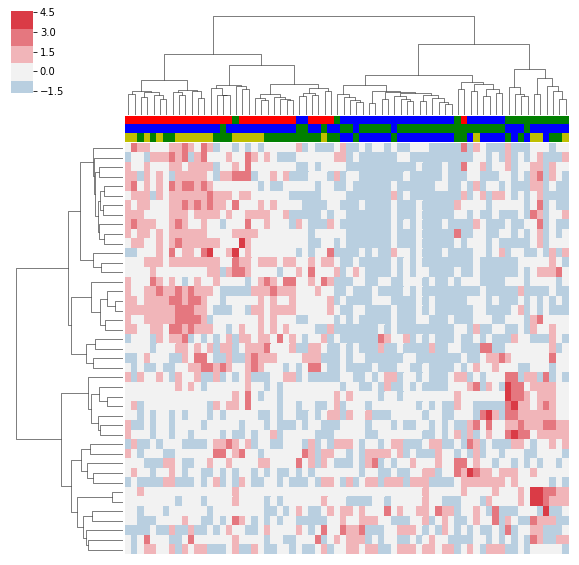

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

#col_order = assign.sort_values(1).index.values

g = sns.clustermap(exp.reindex(genes).dropna(),
                   z_score=0,
                   method='ward',
                   center=0,
                   col_colors=[col_colors, m3c5000_colors, m3c500_colors],
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/NBL-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

In [35]:
# Correlate clusters with NBL clinical features
pth = '../data/meta/target-features-v2.tsv'
features = pd.read_csv(pth, sep='\t')
def feature_map(df, features):
    
    output = pd.DataFrame(columns=['cluster', 
                                   'sample', 
                                   'feature', 
                                   'value'])
    
    for cluster, rows in df.groupby(1):
        roots = ['-'.join(s.split('-')[:3]) for s in rows['index'].values]
        _f = features[features['root'].isin(roots)]
        for feature, value in _f.iterrows():
            output.loc[len(output), :] = [cluster, 
                                          value['root'], 
                                          value['feature'], 
                                          value['value']]
    return output

data = feature_map(assign.reset_index(),
                   features)

from collections import Counter

feature_clusters = pd.DataFrame(columns=['feature', 'value', 'cluster', 'fraction', 'count'])

for (feature, value), rows in data.groupby(['feature', 'value']):
    c = Counter(rows['cluster'].values)
    for cluster, count in c.items():
        frac = (count + 0.0) / sum(c.values())
        feature_clusters.loc[len(feature_clusters), :] = [feature, 
                                                          value, 
                                                          cluster, 
                                                          frac, 
                                                          count]
        
        
def _fisher(m):
    temp = os.path.join(tempfile.gettempdir(), 'M' + str(uuid.uuid4()))
    np.savetxt(temp, m, delimiter='\t')
    
    cmd = ['Rscript',
           os.path.join(src, 'bin', 'fisher.R'),
           temp]
    
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    
    stdout, stderr = p.communicate()
    
    return float(stdout)
        
def fisher(feature, value, df, background=None, mod=None):
    m = np.zeros((2, len(df['cluster'].unique())))
    
    for cluster, rows in df.groupby('cluster'):
        m1 = (rows['feature'] == feature) & (rows['value'] == value) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
        
        if background is None:
            m2 = (rows['feature'] == feature) & (rows['value'] != value) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
            
            #print rows[m2]
        
        else:
            m2 = (rows['feature'] == feature) & (rows['value'] == background) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
        
        n1 = rows[m1].shape[0]
        n2 = rows[m2].shape[0]
        
        # 1-indexed
        m[0, cluster - 1] += n1
        m[1, cluster - 1] += n2
        
    if m[0, :].sum() > m[1, :].sum():
        print("WARNING: Feature count is greater than background!")
    
    if mod is not None:
        for i, v in enumerate(mod):
            m[0, i] += v
        
    nr, nc = m.shape

    return _fisher(m), m


features.loc[features['feature'] == '%tumor', 'value'] = pd.to_numeric(features.loc[features['feature'] == '%tumor', 'value'])

features.loc[features['feature'] == 'age', 'value'] = pd.to_numeric(features.loc[features['feature'] == 'age', 'value'])

In [36]:
mf = pd.DataFrame(columns=['feature', 
                           'alteration', 
                           'p-value',
                           'cluster1',
                           'cluster2',
                           'cluster3',
                           'background1',
                           'background2',
                           'background3'])

molecular_features = [('ATRX', 'deleted', None), 
                      ('ALK', 'mutated', None),
                      ('1q+', 'gain', None),
                      ('1p-', 'loss', None),
                      ('11q-', 'loss', None),
                      ('17q+', 'gain', None),
                      ('MKI', 'low', None),
                      ('MKI', 'intermediate', None),
                      ('MKI', 'high', None),
                      ('Grade', 'differentiating', None)]

for feature, alteration, background in molecular_features:
    print feature, alteration
    p, m = fisher(feature, alteration, data, background=background)
    print p
    print m
    
    mf.loc[len(mf), :] = [feature, alteration, p] + list(m.flatten())

mf.sort_values('p-value').to_csv('../data/meta/molecular-feature-table.tsv', 
                                 sep='\t',
                                 index=False)

ATRX deleted
0.0373085
[[ 7.  0.  0.]
 [22. 16.  9.]]
ALK mutated
0.5305588
[[ 2.  3.  1.]
 [27. 13. 12.]]
1q+ gain
0.169861
[[ 4.  6.  2.]
 [25. 10. 11.]]
1p- loss
0.05707522
[[ 1.  4.  2.]
 [28. 12. 11.]]
11q- loss
0.3168828
[[23.  9. 10.]
 [ 6.  7.  3.]]
17q+ gain
0.006128815
[[29. 12. 10.]
 [ 0.  4.  3.]]
MKI low
0.008846356
[[ 4.  9.  6.]
 [22.  9.  4.]]
MKI intermediate
0.1768113
[[15.  6.  3.]
 [11. 12.  7.]]
MKI high
0.4997228
[[ 7.  3.  1.]
 [19. 15.  9.]]
Grade differentiating
0.01142585
[[ 0.  3.  3.]
 [27. 17.  7.]]


In [37]:
# Load TME profiling tools
pth = '../data/immune/CIBERSORT.Output_Job17-target-mycn-na.txt'
ciber = pd.read_csv(pth, index_col=0, sep='\t')

pth = '../data/immune/mycn-na-target-estimate.tsv'
est = pd.read_csv(pth, sep='\t', comment='#', header=1, index_col=0)
est.drop('Description', axis=1, inplace=True)
est.columns = [x.replace('.', '-') for x in est.columns]

pth = '../data/immune/xCell_target-high-risk-nbl-mycn-na-exp-2018-11-12_xCell_1754032119.txt'
xcell = pd.read_csv(pth, sep='\t', index_col=0)
xcell.columns = [x.replace('.', '-') for x in xcell.columns]

In [38]:
# Save TME profiling data in dataframe
immune_groups = dict((group, []) for group in assign[1].unique())
immune = pd.DataFrame(columns=['sample', 'cluster', 'source', 'feature', 'value'])
for sample in assign.index.values:
    if sample not in ciber.index.values:
        print 'Misisng: ', sample
        continue
        
    assignment = assign.loc[sample, 1]
    
    immune_groups[assignment].append(sample)
    
    for score in ['StromalScore', 'ImmuneScore', 'ESTIMATEScore']:
        _est = est.loc[score, sample].item()
        immune.loc[len(immune), :] = [sample, assignment, 'Estimate', score, _est]
        
    immune.loc[len(immune), :] = [sample, assignment, 
                                'Estimate', 'TumorPurity', 
                                np.cos(0.6049872018 + 0.0001467884 * _est)]
    
    pvalue = ciber.loc[sample, 'P-value'].item()
    for cell, value in ciber.loc[sample, :].iteritems():
        immune.loc[len(immune), :] = [sample, assignment, 'CIBERSORT', cell, value]
        
    for cell, value in xcell[sample].iteritems():
        immune.loc[len(immune), :] = [sample, assignment, 'xCell', cell, value]

skip = ['P-value', 'Pearson Correlation', 'RMSE']        
immune = immune[~immune['feature'].isin(skip)]        
immune['value'] = pd.to_numeric(immune['value'])

In [39]:
# Identify statistically significant correlations
sigs = collections.defaultdict(list)

p_values = pd.DataFrame(columns=['source', 
                                 'feature', 
                                 'A', 
                                 'B', 
                                 'holm p-value'])

for source, rows in immune.groupby('source'):
    print source
    nfeatures = len(rows['feature'].unique())
    alpha = 1 - (1 - 0.05) ** (1.0 / nfeatures)
    for feature in rows['feature'].unique():
        print(feature)
        groups3 = []
        for i, rows in immune[immune['feature'] == feature].groupby('cluster'):
            groups3.append(list(rows['value'].values))
            print i, rows['value'].mean()
    
        try:
            stat, pvalue = kruskal(*groups3)
            print(feature, pvalue, pvalue < alpha)
        
        except Exception as e:
            print e
            continue
    
        if pvalue < alpha:
            sigs[source].append(feature)
            
            try:
                res = sp.posthoc_mannwhitney(groups3, 
                                             p_adjust='holm')
                
            except Exception as e:
                print e
                continue
            
            for i, j in itertools.combinations(range(len(groups3)),
                                               2):
                
                if i == j:
                    continue 
                    
                p_values.loc[len(p_values), :] = [source,
                                                  feature,
                                                  i, 
                                                  j,
                                                  res.iloc[i, j]]

CIBERSORT
B cells naive
1 0.10499854775854042
2 0.019752905308562888
3 0.03350684030316408
('B cells naive', 5.102947661473475e-05, True)
B cells memory
1 0.0512232277502172
2 0.05150987321882916
3 0.02463152298310199
('B cells memory', 0.2099743280584646, False)
Plasma cells
1 0.05482474108434639
2 0.05602923516146801
3 0.05253436938309364
('Plasma cells', 0.5065261161600244, False)
T cells CD8
1 0.13560369395583224
2 0.03729920021885045
3 0.07402657423163263
('T cells CD8', 2.6199780806029447e-06, True)
T cells CD4 naive
1 0.0353262742976005
2 0.036899329756342865
3 0.010660596845789773
('T cells CD4 naive', 0.13572331415641828, False)
T cells CD4 memory resting
1 0.020440811117374433
2 0.08483298772661249
3 0.05669871397485885
('T cells CD4 memory resting', 0.03503518276271658, False)
T cells CD4 memory activated
1 0.00223097826533371
2 0.011429036071284506
3 0.02783823518395578
('T cells CD4 memory activated', 0.12049190601957332, False)
T cells follicular helper
1 0.08259781559497

Tgd cells
1 0.0
2 0.0
3 0.0
All numbers are identical in kruskal
Th1 cells
1 0.024861290322580644
2 0.024453846153846152
3 0.008638461538461538
('Th1 cells', 0.036219244141298367, False)
Th2 cells
1 0.2675677419354839
2 0.21880384615384615
3 0.09278461538461538
('Th2 cells', 0.0011273206263101676, False)
Tregs
1 0.0
2 0.0031884615384615385
3 0.0017923076923076924
('Tregs', 0.04363100280692757, False)
aDC
1 0.4755
2 0.18360384615384617
3 0.4231230769230769
('aDC', 5.024909262335805e-08, True)
cDC
1 0.16354193548387094
2 0.07187692307692307
3 0.1520384615384615
('cDC', 9.624248675273983e-06, True)
iDC
1 0.12328064516129032
2 0.05486153846153847
3 0.10713076923076924
('iDC', 0.05847349320661659, False)
ly Endothelial cells
1 0.013916129032258067
2 0.008696153846153847
3 0.0232
('ly Endothelial cells', 0.03044615037365192, False)
mv Endothelial cells
1 0.02012258064516129
2 0.011626923076923078
3 0.020100000000000003
('mv Endothelial cells', 0.09154686572317904, False)
naive B-cells
1 0.01

0 B cells naive
1 T cells CD8
2 T cells regulatory (Tregs)
3 Monocytes
4 Macrophages M1
5 Eosinophils


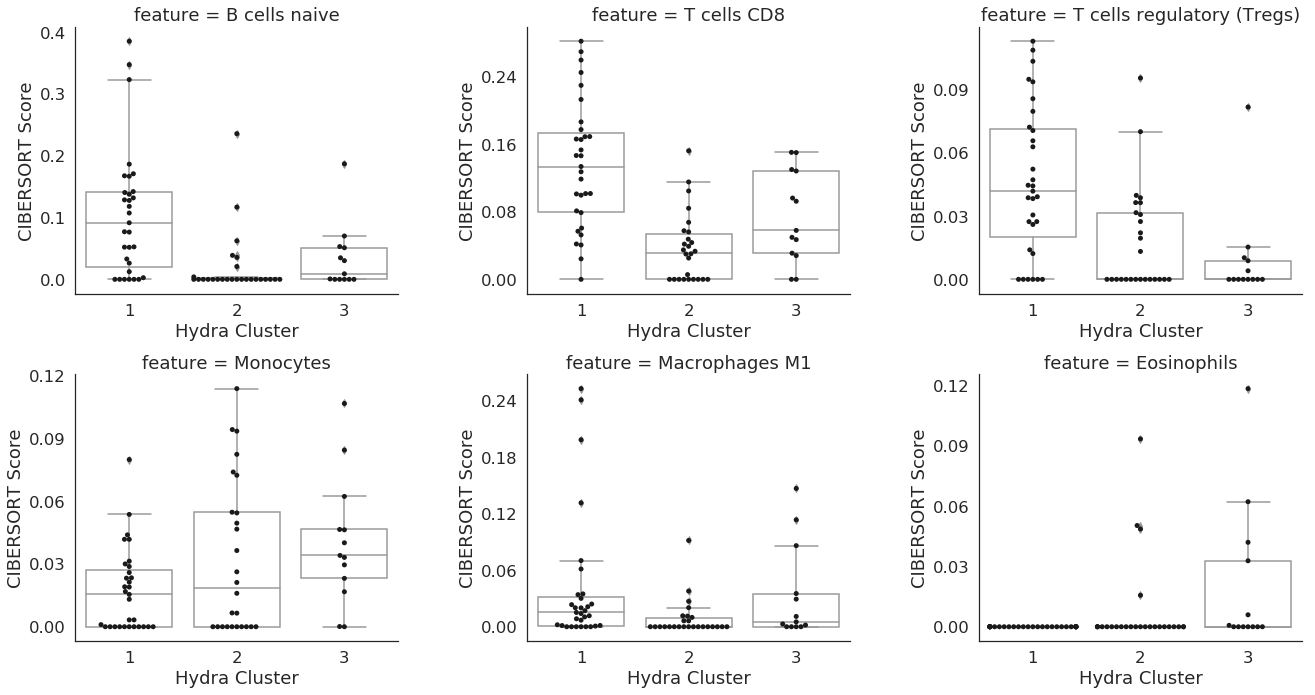

In [40]:
# Plot significant enrichment CIBERSORT
sns.set(font_scale=1.5, style='white')

mask = (immune['source'] == 'CIBERSORT') & (immune['feature'].isin(sigs['CIBERSORT']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                color='white',
                sharex=False,
                sharey=False,
                data=t,
                aspect=1.25)

for i, feature in enumerate(t['feature'].unique()):
    print i, feature
    sns.swarmplot(x='cluster',
                  y='value',
                  color='k',
                  size=5,
                  data=t[t['feature'] == feature],
                  ax=g.axes[i])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('CIBERSORT Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/CIBERSORT-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/CIBERSORT-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

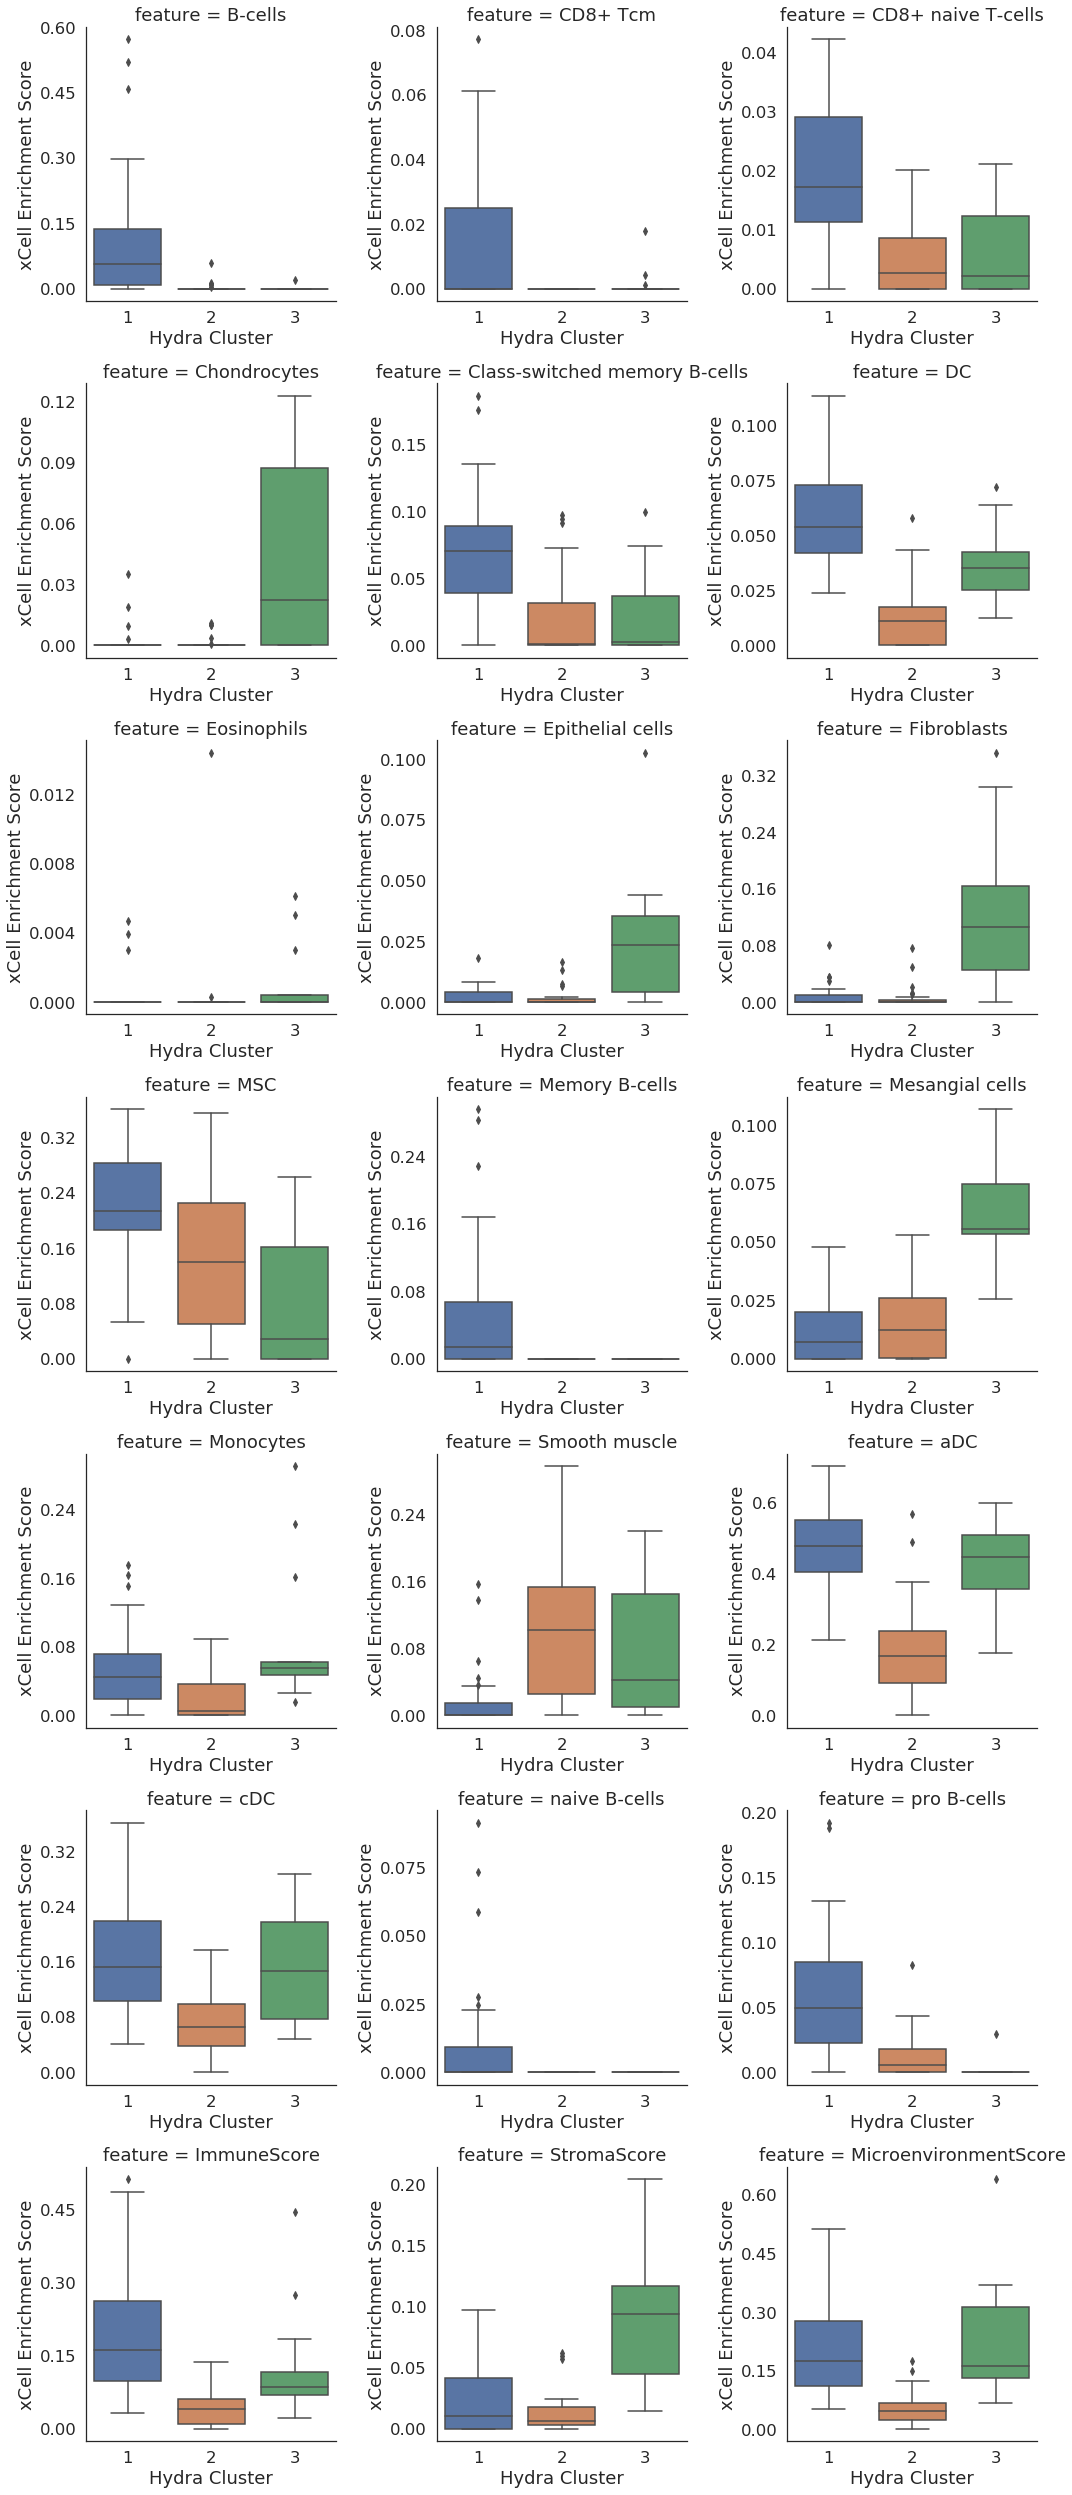

In [41]:
# Plot significant enrichment xCELL
mask = (immune['source'] == 'xCell') & (immune['feature'].isin(sigs['xCell']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

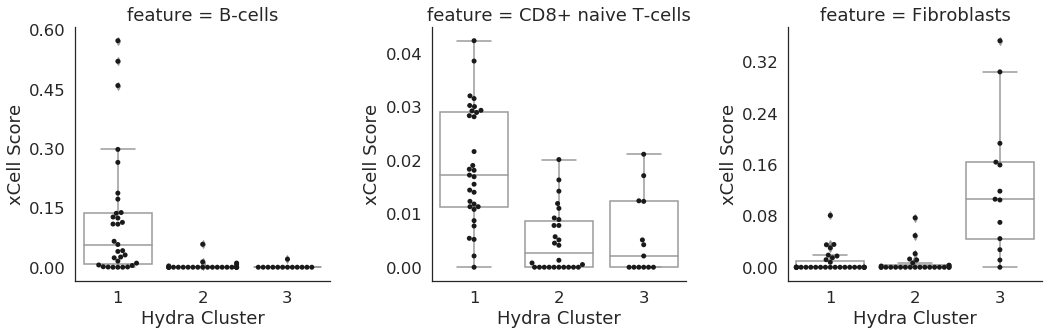

In [42]:
sns.set(font_scale=1.5, style='white')

interest = ["B-cells",
            "CD8+ naive T-cells",
            "Fibroblasts"]

mask = (immune['source'] == 'xCell') & (immune['feature'].isin(interest))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                col_order=interest,
                color='white',
                sharex=False,
                sharey=False,
                data=t)

# CD8+
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'B-cells'],
              ax=g.axes[0])

# CD8+
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'CD8+ naive T-cells'],
              ax=g.axes[1])

# Fibroblasts
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'Fibroblasts'],
              ax=g.axes[2])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/xCell-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/xCell-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

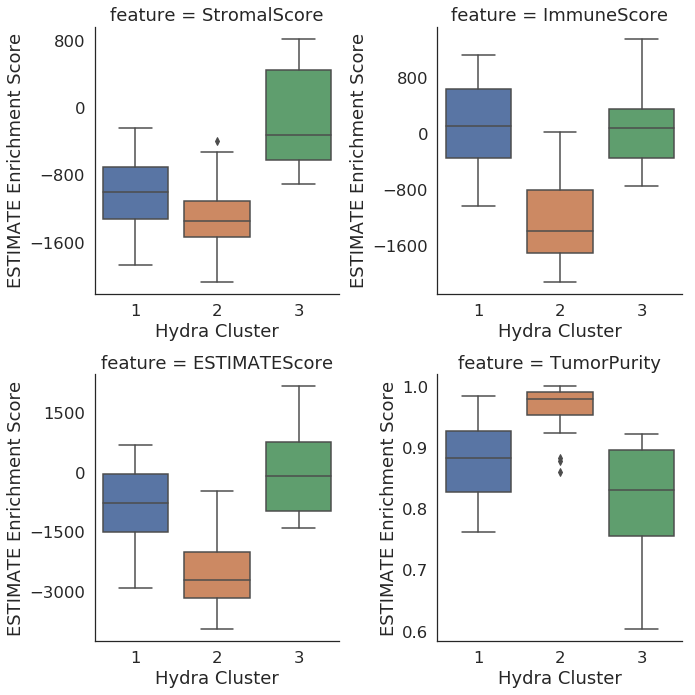

In [43]:
# Plot significant enrichment ESTIMATE
mask = (immune['source'] == 'Estimate') & (immune['feature'].isin(sigs['Estimate']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=2,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('ESTIMATE Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

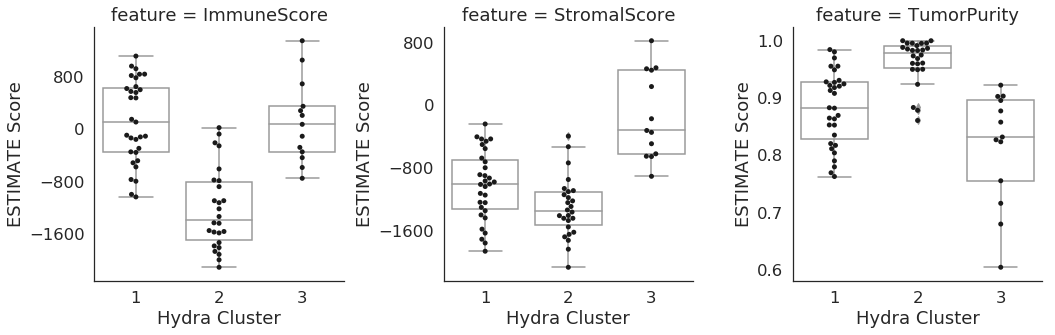

In [44]:
sns.set(font_scale=1.5, style='white')

interest = ["ImmuneScore",
            "StromalScore",
            "TumorPurity"]

mask = (immune['source'] == 'Estimate') #& (immune['feature'].isin(sigs['Estimate']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                col_order=interest,
                color='white',
                sharex=False,
                sharey=False,
                data=t)

# Immune Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'ImmuneScore'],
              ax=g.axes[0])

# Stromal Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'StromalScore'],
              ax=g.axes[1])

# Stromal Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'TumorPurity'],
              ax=g.axes[2])


for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('ESTIMATE Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/ESTIMATE-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/ESTIMATE-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [ ]:
# Load ATRX features
mask = (features['feature'] == 'ATRX') & (features['value'] == 'deleted')
atrx = features.loc[mask, 'root'].values

In [ ]:
# Check for relationship between tumor purity
# and clustering. 
m = np.zeros((2, max(assign[1])))

tperc = pd.DataFrame(columns=['sample', '%tumor', 'cluster'])
for sample in exp.columns:
    root = '-'.join(sample.split('-')[:3])
    mask = (features['root'] == root) & (features['feature'] == '%tumor')
    v = features.loc[mask, 'value'].item()
    if pd.isnull(v):
        continue
        
    c = assign.loc[sample, 1]
        
    if v > 75:
        m[1, c - 1] += 1
        
    else:
        
        m[0, c - 1] += 1
        
    if root in atrx:
        print sample, v, assign.loc[sample, 1]
        
    tperc.loc[len(tperc), :] = [sample, v, c]
        
tperc['%tumor'] = pd.to_numeric(tperc['%tumor'])

print m
        
_fisher(m)

In [ ]:
# Plot percent tumor values across clusters
fig, ax = plt.subplots(1, figsize=(6, 5))

sns.boxplot(x='cluster', 
            y ='%tumor', 
            data=tperc,
            color='white',
            ax=ax)

sns.swarmplot(x='cluster', 
              y ='%tumor', 
              data=tperc,
              color='k',
              ax=ax)

tgroups = []
for c, rows in tperc.groupby('cluster'):
    tgroups.append(list(rows['%tumor'].values))
    
ax.set_xlabel('Cluster')
ax.set_ylabel('Percent Tumor')

pth = '../img/perc-tumor-dist.svg'

plt.savefig(pth,
            format='svg',
            bbox_inches='tight')

print kruskal(*tgroups)

sp.posthoc_mannwhitney(tgroups, 
                       p_adjust='holm')

In [ ]:
# Create colorbar for heatmap

annotations = []

atrx_a = []
atrx_samples = []

hydra_cols = []

m3c5000_cols = []
m3c500_cols = []

for sample in assign.sort_values(1).index.values:
    root = '-'.join(sample.split('-')[:3])
    cluster = assign.loc[sample, 1]
    
    if cluster == 1:
        hydra_cols.append("#3274a1")
        
    elif cluster == 2:
        hydra_cols.append("#e1812c")
        
    elif cluster == 3:
        hydra_cols.append("#3a923a")
        
    elif cluster == 4:
        hydra_cols.append("orange")
     
    if root in atrx:
        atrx_a.append('red')
        atrx_samples.append(sample)
         
    else:
        atrx_a.append('gray')

    m3c5000_c = m3c5000.loc[sample, 'consensuscluster']
    m3c500_c = m3c500.loc[sample, 'consensuscluster']
    
    if m3c5000_c == 1:
        m3c5000_cols.append('#0e4220')
        
    elif m3c5000_c == 2:
        m3c5000_cols.append('#542788')
        
    else:
        raise ValueError()
        
    if m3c500_c == 1:
        m3c500_cols.append('#7F002B')
        
    elif m3c500_c == 2:
        m3c500_cols.append('#C8C8C8')
        
    elif m3c500_c == 3:
        m3c500_cols.append('#8BC3C0')
        
    else:
        raise ValueError()
    
    
        
        
annotations.append(hydra_cols)
annotations.append(m3c5000_cols)
annotations.append(m3c500_cols)
annotations.append(atrx_a)

In [ ]:
# Make dendrogram for clustering

import collections

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, cophenet, linkage, dendrogram
from scipy.spatial.distance import pdist;

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata;


zscore_df = exp.reindex(genes).dropna().apply(lambda x: (x - x.mean()) / x.std(), axis=1) 

method = 'ward'
metric = 'euclidean'

row_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values), 
    method=method, metric=metric)

col_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values.T), 
    method=method, metric=metric);

dist = 17

fancy_dendrogram(
    col_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=dist,
)
plt.show()

clusters = fcluster(col_linkage, dist, criterion='distance')

cmap = sns.color_palette("Set2", max(clusters))

rcolors = [cmap[i - 1] for i in clusters]

groups = collections.defaultdict(list)
for sample, cluster in zip(zscore_df.columns, clusters):
    groups[cluster].append(sample);

In [ ]:
# Cluster rows and assign function

dist = 18

fancy_dendrogram(
    row_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=dist,
)
plt.show()

rclusters = fcluster(row_linkage, dist, criterion='distance')

rcmap = sns.color_palette("Set2", max(rclusters))

_rcolors = [rcmap[i -1] for i in rclusters]

rgroups = collections.defaultdict(list)
for sample, cluster in zip(zscore_df.index, rclusters):
    rgroups[cluster].append(sample);

In [ ]:
import seaborn as sns

col_order = assign.sort_values(1).index.values

g = sns.clustermap(exp.reindex(genes).dropna().reindex(col_order, axis=1),
                   col_cluster=False,
                   row_linkage=row_linkage,
                   col_colors=annotations,
                   row_colors=_rcolors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/micro-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/micro-expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [ ]:
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu

checkpoint = pd.DataFrame(columns=['sample',
                                   'cluster', 
                                   'gene', 
                                   'value'])

for sample in exp.columns:
    cluster = assign.loc[sample, 1]
    for gene in ['CD274', 'CTLA4']:
        checkpoint.loc[len(checkpoint), :] = [sample,
                                              cluster, 
                                              gene, 
                                              exp.loc[gene, sample]]
        
checkpoint['value'] = pd.to_numeric(checkpoint['value'])

sns.set(font_scale=1.5, style='white')

g = sns.catplot(x='cluster', 
                y='value', 
                col='gene',
                kind='box',
                col_wrap=2,
                color='white',
                sharex=False,
                sharey=False,
                data=checkpoint)

sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=checkpoint[checkpoint['gene'] == 'CD274'],
              ax=g.axes[0])

# CD8+ T-cells
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=checkpoint[checkpoint['gene'] == 'CTLA4'],
              ax=g.axes[1])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('Expression (log2(TPM + 1))')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/Checkpoint-Plots-V1.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

for gene in ['CD274', 'CTLA4']:
    print gene
    print sp.posthoc_mannwhitney(checkpoint[checkpoint['gene'] == gene],
                           val_col='value',
                           group_col='cluster',
                           p_adjust='fdr_bh')

In [ ]:
pth = '../data/meta/ng.2529-S2.xlsx'

pugh = pd.read_excel(pth, index_col=0, header=1)

burden = pd.DataFrame(columns=['sample', 'burden', 'cluster'])

for sample in exp.columns:
    
    cluster = assign.loc[sample, 1]
    root = '-'.join(sample.split('-')[:3])
    
    try:
        bd = pugh.loc[root, 'Nonsilent per Mb']
        
    except KeyError:
        print 'Missing: ', sample
        continue
        
    burden.loc[len(burden), :] = [sample, bd, cluster]
    
burden['burden'] = pd.to_numeric(burden['burden'])

fig, ax = plt.subplots(1, 
                       figsize=(5, 5))

g = sns.boxplot(x='cluster',
                y='burden',
                data=burden,
                color='white',
                ax=ax)


sns.swarmplot(x='cluster',
              y='burden',
              data=burden,
              color='k',
              size=5,
              ax=ax)

g.set_xlabel('Hydra Cluster')
g.set_ylabel('Nonsilent Mutations / Mb')

pth = '../img/mutation-burden.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

In [ ]:
assign

In [ ]:
!ls ../data/cluster-analysis/

In [ ]:
import glob 
from sklearn.metrics import adjusted_rand_score

# Clustering Analysis

_dir = '../data/cluster-analysis/'

cluster_screen = pd.DataFrame(columns=['Method', 'Threshold', 'Clusters', 'Rand Index'])
for pth in glob.glob(os.path.join(_dir, 'MYCN-NA-*labels*')):
    print(pth)
    if "MYCN-NA-M3C.tsv" in pth:
        continue
        
    b = os.path.basename(pth)
    fields = b.split('-')
    
    method = fields[2] if fields[2] == 'M3C' else 'Gap Statistic\nKmeans'
    threshold = fields[4]
    clusters = fields[-1].replace('.tsv', '')
    
    
    labels = pd.read_csv(pth, sep='\t')
    samples = [x.replace('.', '-') for x in labels.index.values]
    labels.index = samples
    
    if method == 'M3C':
        clustering = labels.reindex(assign.index)['consensuscluster'].values
            
    else:
        clustering = labels.reindex(assign.index)['x'].values
    
    hydra_clusters = assign[1].values
    ri = adjusted_rand_score(clustering, hydra_clusters)
    
    cluster_screen.loc[len(cluster_screen), :] = [method, threshold, clusters, ri]
    
cluster_screen['Threshold'] = pd.to_numeric(cluster_screen['Threshold'])
cluster_screen['Clusters'] = pd.to_numeric(cluster_screen['Clusters'])
cluster_screen['Rand Index'] = pd.to_numeric(cluster_screen['Rand Index'])

In [ ]:
cluster_screen

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(x='Threshold', 
            y='Clusters', 
            hue='Method',
            data=cluster_screen, ax=ax)

ax.set_yticks(range(7))
ax.set_yticklabels(range(7))
ax.set_xlabel("Median Absolute Deviation (MAD) Threshold")

ax.legend(bbox_to_anchor=(1.5, 1.0), frameon=False)

ax2 = ax.twinx()
sns.pointplot(x='Threshold', 
            y='Rand Index', 
            hue='Method', 
            data=cluster_screen,
            ax=ax2)

ax2.get_legend().remove()

plt.savefig('../img/clustering-screen.svg', 
            format='svg', 
            bbox_inches='tight')

In [ ]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm']
    
    if event == 'Censored':
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../data/meta/TARGET_NBL_ClinicalData_Discovery_20170525.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=assign.index, 
                    columns=['OS', 'vital', 'EFS', 'event', 'cluster'])

for sample in assign.index.values:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    event = get_event(clinical.loc[root, 'First Event'])
    
    cluster = assign.loc[sample, 1]
    if cluster == 3:
        continue
    
    surv.loc[sample, :] = [OS, vital, EFS, event, cluster]

In [ ]:
survpth = '../data/mycn-na-survival.tsv'
surv.to_csv(survpth, sep='\t')

In [ ]:
surv